<a href="https://colab.research.google.com/github/thursdaydreaming/whitescan/blob/main/konlp_word2vec_%2C_fasttext_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#모듈 설치하기
!pip install sklearn
!pip install konlpy

In [ ]:
!pip install gensim
!pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import nltk
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
import csv
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import pickle
import re
import numpy as np
import konlpy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install soynlp
!pip show soynlp

In [ ]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
#!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [ ]:
data = pd.read_excel("drive/MyDrive/similar_data.xlsx", sheet_name='요식')
print(data)

     대분류      중분류    브랜드                     상품
0     요식  한식 음식점업     한솥           비벼먹는 치킨마요 김밥
1     요식  한식 음식점업     한솥           비벼먹는 참치마요 김밥
2     요식  한식 음식점업     한솥         비벼먹는 소불고기마요 김밥
3     요식  한식 음식점업     한솥  국물떡볶이 & 토네이도소세지 튀김set
4     요식  한식 음식점업     한솥                 국물 떡볶이
...   ..      ...    ...                    ...
5637  요식   카페 전문점  더착한커피              엘더플라워 에이드
5638  요식   카페 전문점  더착한커피                 생과일 주스
5639  요식   카페 전문점  더착한커피                    팥빙수
5640  요식   카페 전문점  더착한커피                    흑임자
5641  요식   카페 전문점  더착한커피                    오레오

[5642 rows x 4 columns]


In [ ]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [ ]:
!pip install gensim
!pip show gensim

Name: gensim
Version: 3.6.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, six, smart-open
Required-by: 


In [ ]:
%time sentences = data['상품'].apply(preprocessing)

CPU times: user 20.7 ms, sys: 0 ns, total: 20.7 ms
Wall time: 25.6 ms


In [ ]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer

In [ ]:
%time tokens = sentences.apply(tokenizer.tokenize)
tokens[:]

In [ ]:
# word2vec 모델 학습에 로그를 찍을 수 있도록 합니다.
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [ ]:
# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
%time model = word2vec.Word2Vec(tokens, min_count=1)

model

In [ ]:
# 모델 이름을 지정하고 저장한다.
model_name = '1minwords'
model.save(model_name)

2021-08-24 07:58:40,087 : INFO : saving Word2Vec object under 1minwords, separately None
2021-08-24 07:58:40,091 : INFO : not storing attribute vectors_norm
2021-08-24 07:58:40,093 : INFO : not storing attribute cum_table
2021-08-24 07:58:40,148 : INFO : saved 1minwords


In [ ]:
# 단어 사전 수
len(model.wv.vocab)

3910

In [ ]:
# 단어 사전에서 상위 10개만 보기
vocab = model.wv.vocab
sorted(vocab, key=vocab.get, reverse=True)[:30]

In [ ]:
vocab

Word2vec 테스트

In [ ]:
# Counter로 자주 등장하는 단어 보기
from collections import Counter
dict(Counter(vocab).most_common(20))

In [ ]:
# 가장 적게 등장하는 단어
min(vocab, key=vocab.get)

'소불고기마요'

In [ ]:
model.wv['아이스']

array([-1.1209440e-03, -3.0250465e-03,  1.6823597e-03, -3.8785753e-03,
       -3.7912098e-03, -4.6397736e-03, -4.2720730e-03, -4.0824530e-03,
       -6.1995280e-04, -5.4546609e-03,  2.7098674e-03,  5.1177982e-03,
        2.8086784e-03,  1.3095384e-03, -1.5983813e-03, -3.7905658e-03,
        3.5924211e-03,  2.0398020e-03, -4.6620360e-03,  3.4751226e-03,
        3.7387875e-03, -2.5848372e-04,  4.7297203e-03, -2.4407657e-03,
        2.3118004e-03,  3.3854861e-03,  2.2050524e-03, -4.6990733e-03,
       -1.2141359e-03, -1.5390906e-03,  5.1642763e-03,  3.5308357e-03,
        1.7497705e-03, -5.0177276e-03, -2.8805947e-03,  3.8287616e-03,
       -1.3048119e-03, -3.1282476e-03,  4.7133197e-03, -1.1370440e-03,
        1.0001382e-03, -3.1401236e-03, -3.5963785e-03, -1.2418457e-03,
        1.3026135e-03, -4.9185520e-03, -3.3828062e-03, -4.7899657e-03,
        3.5059042e-03,  3.6889201e-03, -4.3680500e-03,  2.8320928e-03,
       -1.9704755e-03, -4.4252010e-04,  4.4966998e-04,  2.2801459e-03,
      

In [ ]:
model.wv.most_similar('아이스')

2021-08-24 07:58:40,305 : INFO : precomputing L2-norms of word weight vectors


[('치킨데리야끼벤토', 0.3227600157260895),
 ('페스츄리', 0.3109956979751587),
 ('티', 0.2879680097103119),
 ('계란', 0.28713154792785645),
 ('모짜렐라치즈찜닭', 0.2857094705104828),
 ('바닐라밀크쉐이크', 0.28394803404808044),
 ('치즈쿠키', 0.27957087755203247),
 ('고기고기', 0.27448615431785583),
 ('쿠빙', 0.2702702283859253),
 ('크로크무슈', 0.2693765461444855)]

In [ ]:
model.wv.similarity('딸기', '아이스')

-0.14977366

In [ ]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
#!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '1minwords'
model = g.Doc2Vec.load(model_name)

2021-08-24 07:58:40,498 : INFO : loading Doc2Vec object from 1minwords
2021-08-24 07:58:40,550 : INFO : loading wv recursively from 1minwords.wv.* with mmap=None
2021-08-24 07:58:40,551 : INFO : setting ignored attribute vectors_norm to None
2021-08-24 07:58:40,558 : INFO : loading vocabulary recursively from 1minwords.vocabulary.* with mmap=None
2021-08-24 07:58:40,565 : INFO : loading trainables recursively from 1minwords.trainables.* with mmap=None
2021-08-24 07:58:40,567 : INFO : setting ignored attribute cum_table to None
2021-08-24 07:58:40,569 : INFO : loaded 1minwords


In [ ]:
# Doc2Vec으로 만든 모델을 가져옴
vocab = list(model.wv.vocab)
# 모델의 단어를 피처로 지정해 준다.
X = model[vocab]

print('Feature의 길이 {}'.format(len(X)))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 모든 단어를 그래프에 출력하면 글자가 너무 많이 겹치기 때문에 일부 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:150,:])

Feature의 길이 3910
[-0.00467217  0.00294825 -0.0011619   0.00401795 -0.0039078   0.00075818
  0.00052655 -0.00021816 -0.00019672 -0.00267367]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:150], columns=['x', 'y'])
df.shape

(150, 2)

In [ ]:
df.head(20)

,x,y
비벼먹는,-2.476756,-1.000878
치킨마요,1.171063,-0.484456
김밥,-0.610200,-0.204831
참치마요,-0.758522,4.531081
소불고기마요,-6.820974,1.593419
국물떡볶이,-7.576055,0.943378
토네이도소세지,-5.237981,-4.750393
튀김,-5.671195,2.300541
set,-1.421898,-1.040648
국물,-6.173638,-3.213063


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

2021-08-24 07:58:46,738 : INFO : loading Doc2Vec object from 1minwords
2021-08-24 07:58:46,781 : INFO : loading wv recursively from 1minwords.wv.* with mmap=None
2021-08-24 07:58:46,783 : INFO : setting ignored attribute vectors_norm to None
2021-08-24 07:58:46,784 : INFO : loading vocabulary recursively from 1minwords.vocabulary.* with mmap=None
2021-08-24 07:58:46,787 : INFO : loading trainables recursively from 1minwords.trainables.* with mmap=None
2021-08-24 07:58:46,789 : INFO : setting ignored attribute cum_table to None
2021-08-24 07:58:46,792 : INFO : loaded 1minwords


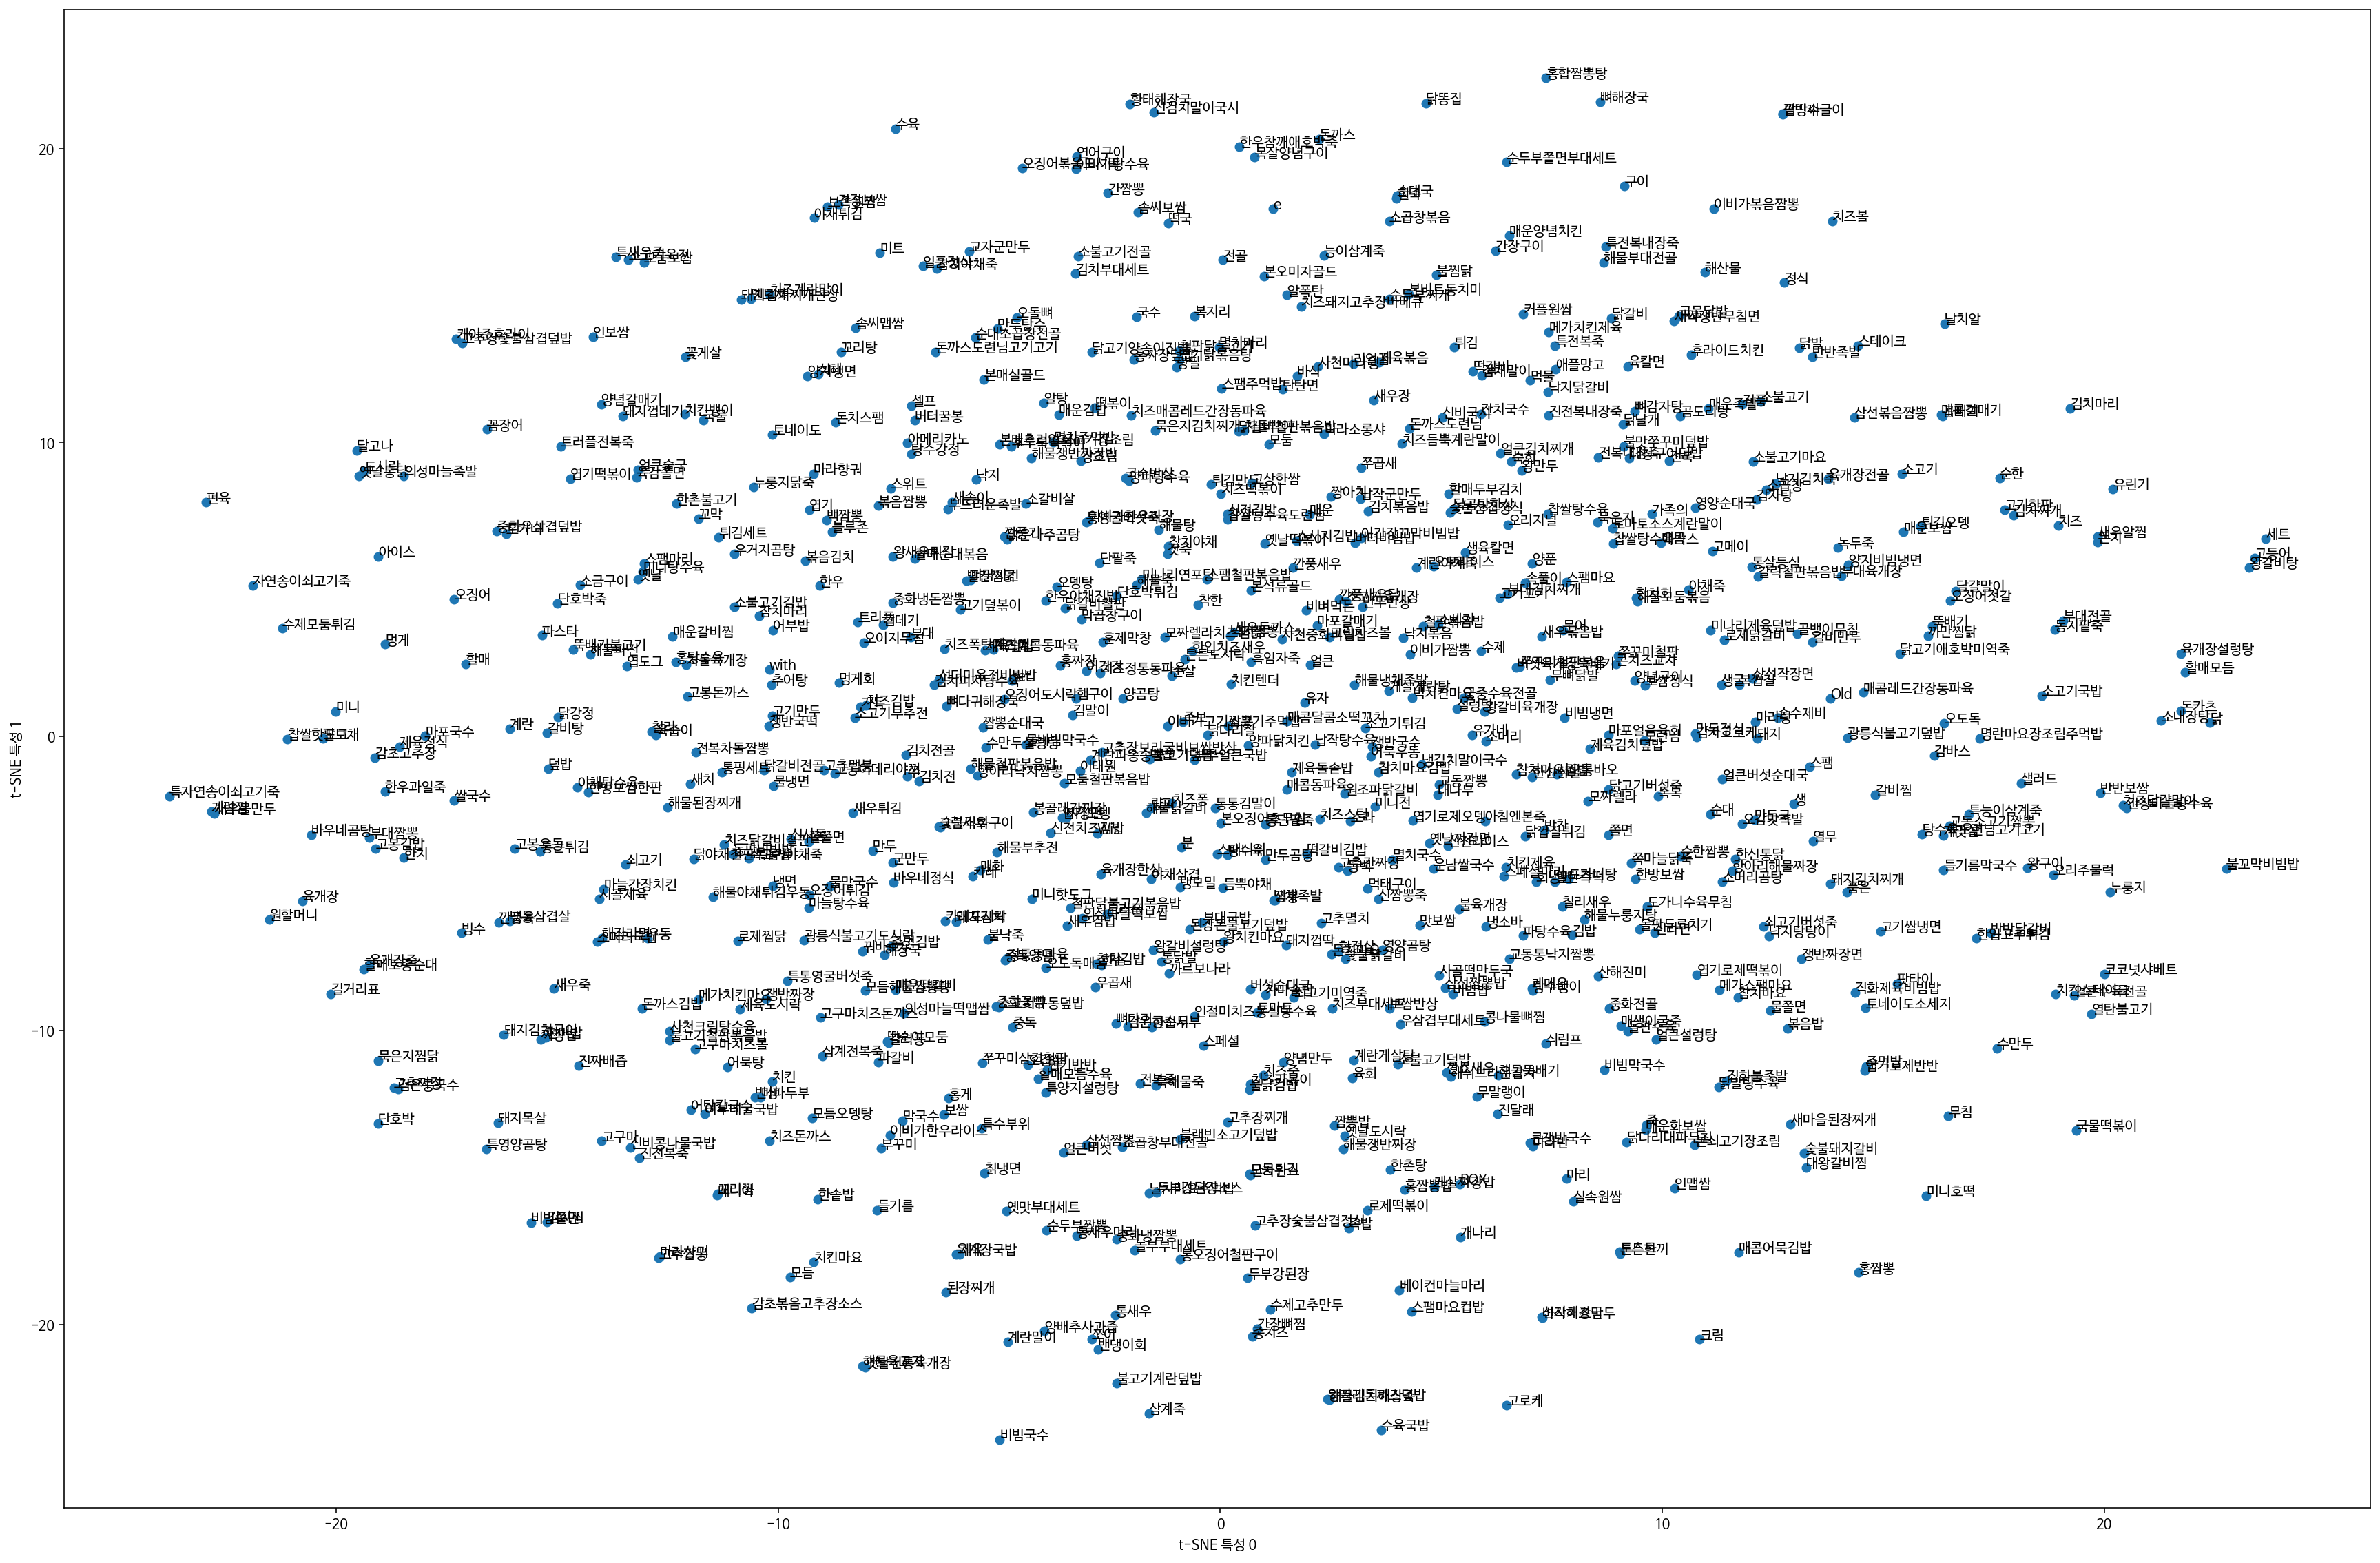

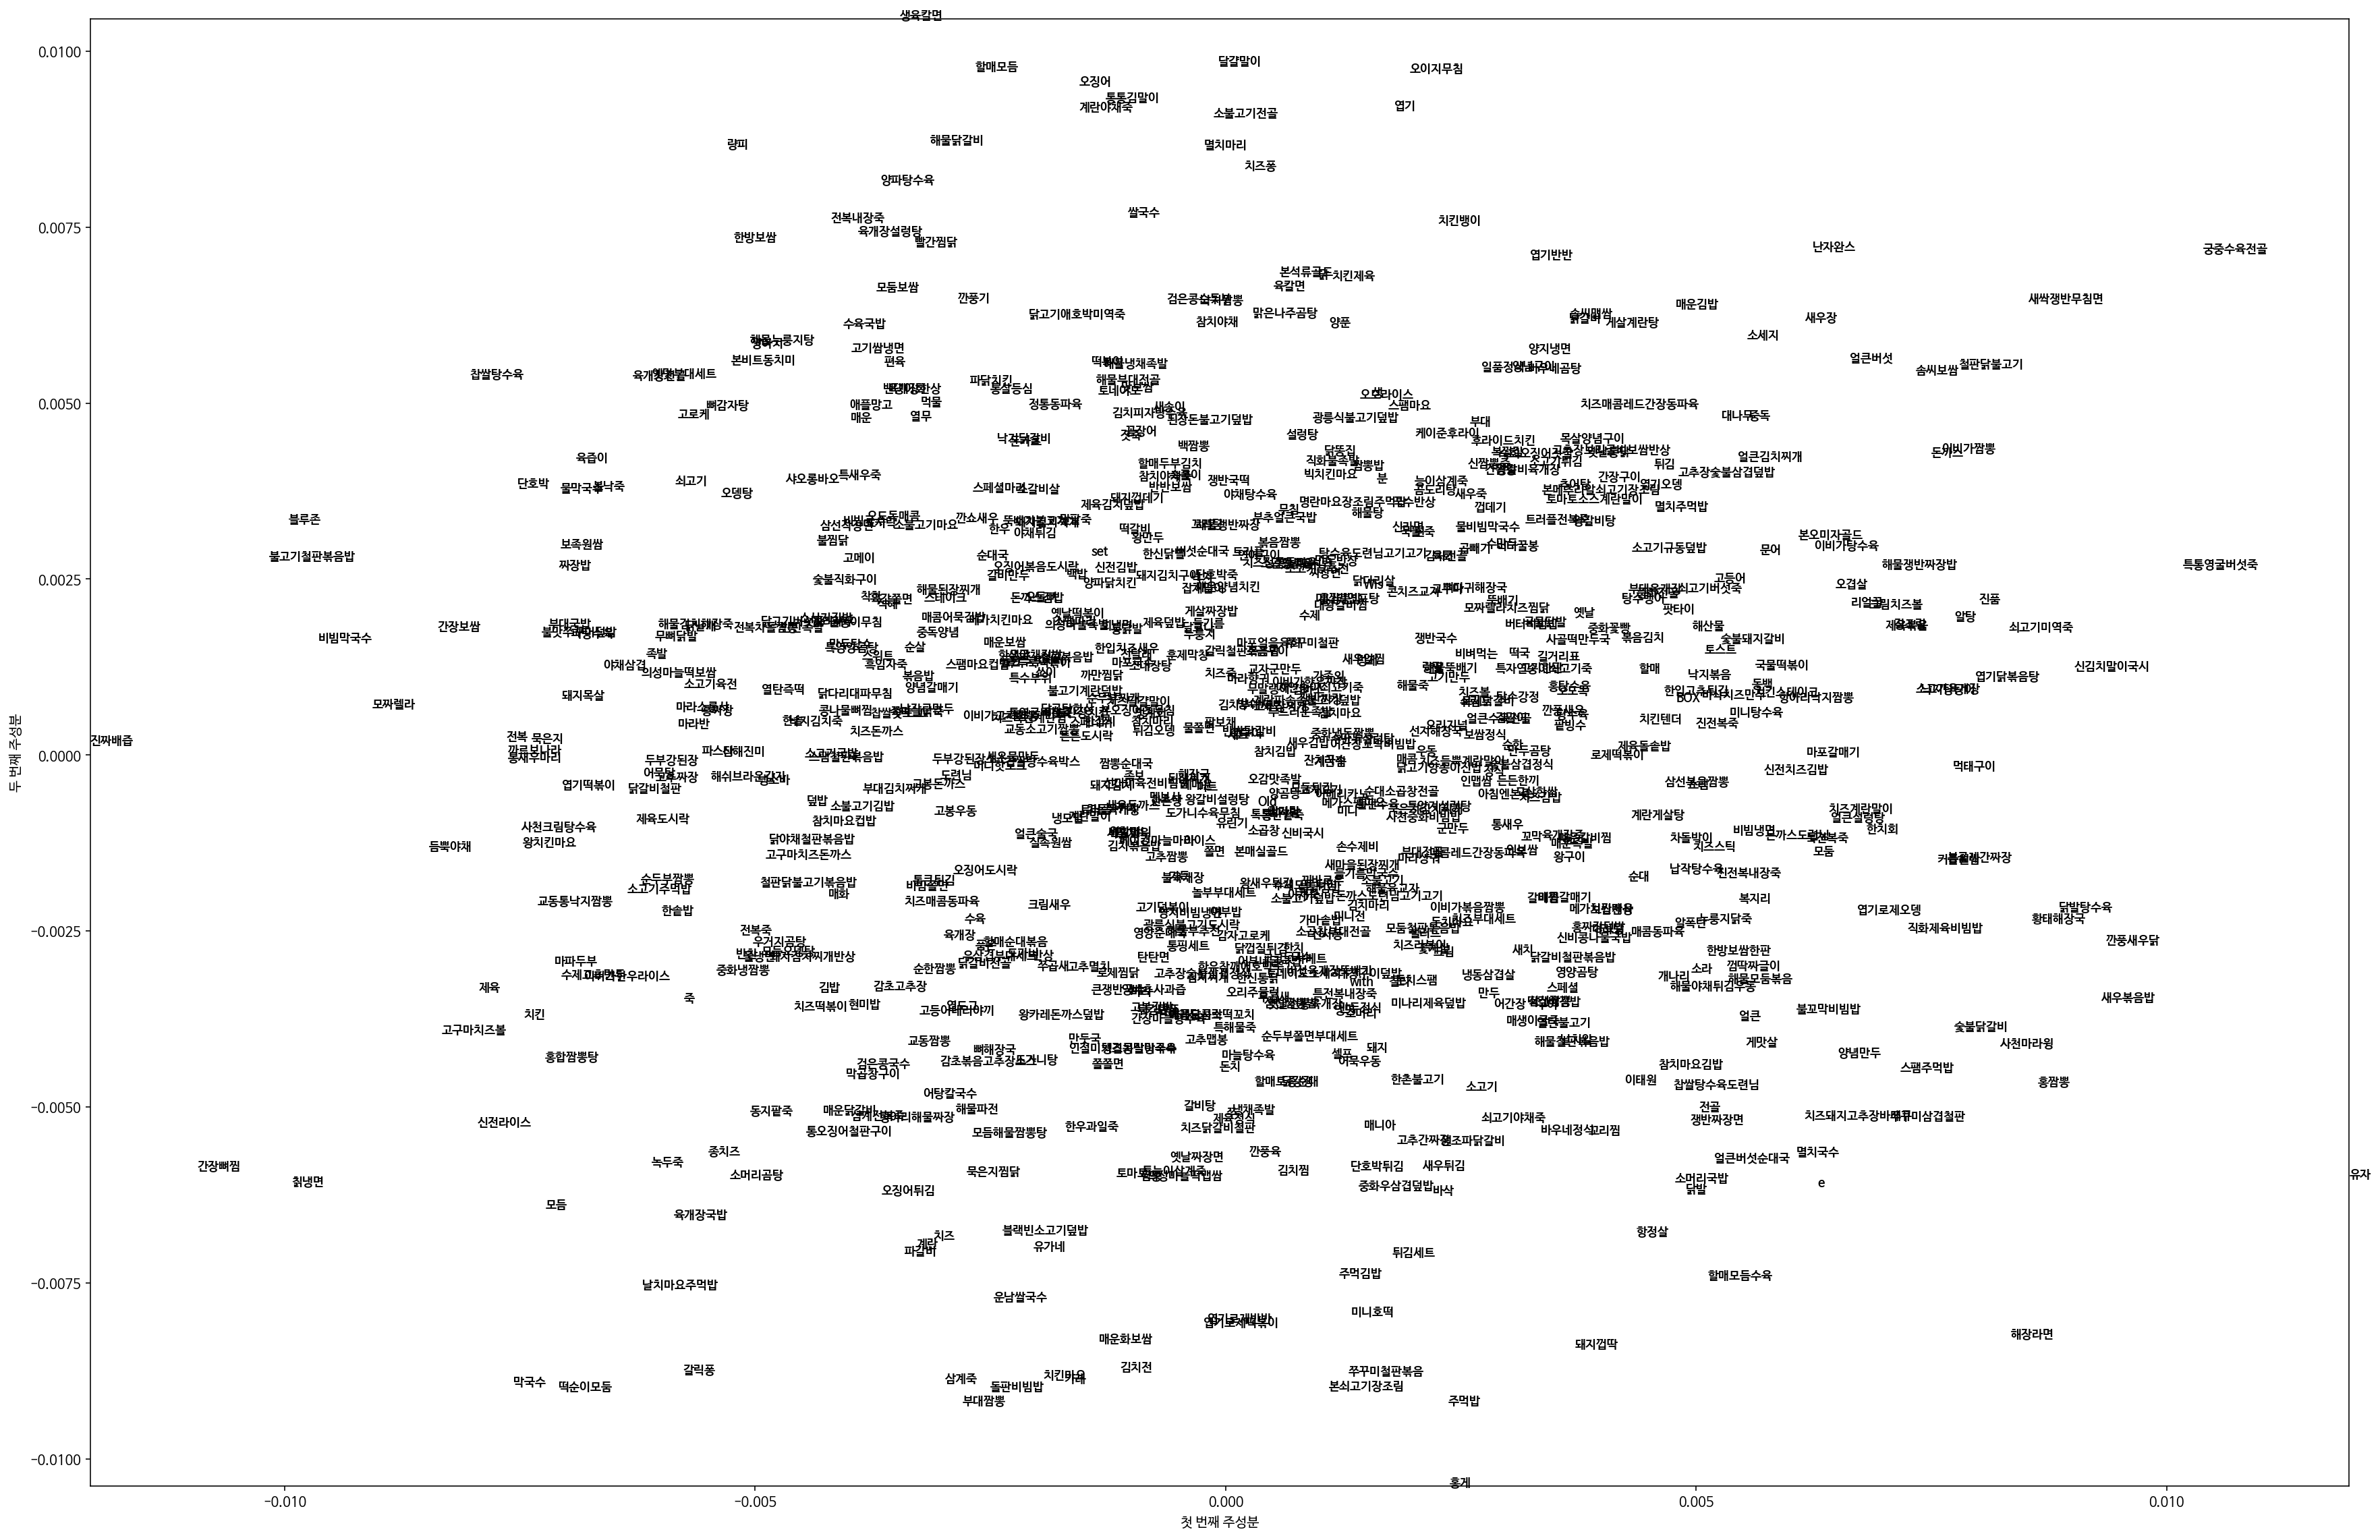

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import pandas as pd 
from gensim.models import KeyedVectors 

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처 
mpl.rcParams['axes.unicode_minus'] = False 

plt.rc('font', family='NanumBarunGothic') 
def show_tsne(): 
  tsne = TSNE(n_components=2) 
  X = tsne.fit_transform(X_show) 
  df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y']) 
  fig = plt.figure() 
  fig.set_size_inches(30, 20) 
  ax = fig.add_subplot(1, 1, 1) 
  ax.scatter(df['x'], df['y']) 
  
  for word, pos in df.iterrows(): 
    ax.annotate(word, pos, fontsize=10) 
    
  plt.xlabel("t-SNE 특성 0") 
  plt.ylabel("t-SNE 특성 1") 
  plt.show() 
  
def show_pca(): 
  # PCA 모델을 생성합니다 
  pca = PCA(n_components=2) 
  pca.fit(X_show) 
  # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다 
  
  x_pca = pca.transform(X_show) 
  
  plt.figure(figsize=(30, 20)) 
  plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max()) 
  plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max()) 
  
  for i in range(len(X_show)): 
    plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]), 
             fontdict={'weight': 'bold', 'size': 9}) 
    
  plt.xlabel("첫 번째 주성분") 
  plt.ylabel("두 번째 주성분") 
  plt.show()

model_name = '1minwords'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab) 
X = model[vocab] 

# sz개의 단어에 대해서만 시각화 
sz = 800 
X_show = X[:sz,:] 
vocab_show = vocab[:sz] 

show_tsne() 

show_pca()

Fasttext

In [ ]:
!pip install fasttext

In [ ]:
import fasttext.util
fasttext.util.download_model('ko', if_exists='ignore')
ft = fasttext.load_model('cc.ko.300.bin')

In [ ]:
ft.get_nearest_neighbors('딸기')

[(0.5935850143432617, '퀘스트完'),
 (0.5581501126289368, '참외'),
 (0.5522404909133911, '밀감'),
 (0.5446791648864746, '단감'),
 (0.5423799157142639, '과일'),
 (0.5420711040496826, '초코'),
 (0.5413011908531189, '망고'),
 (0.5222350358963013, 'いちご'),
 (0.5144596099853516, '두릅'),
 (0.508292555809021, '딸기와')]

In [ ]:
ft.save_model('cc.ko.100.bin')

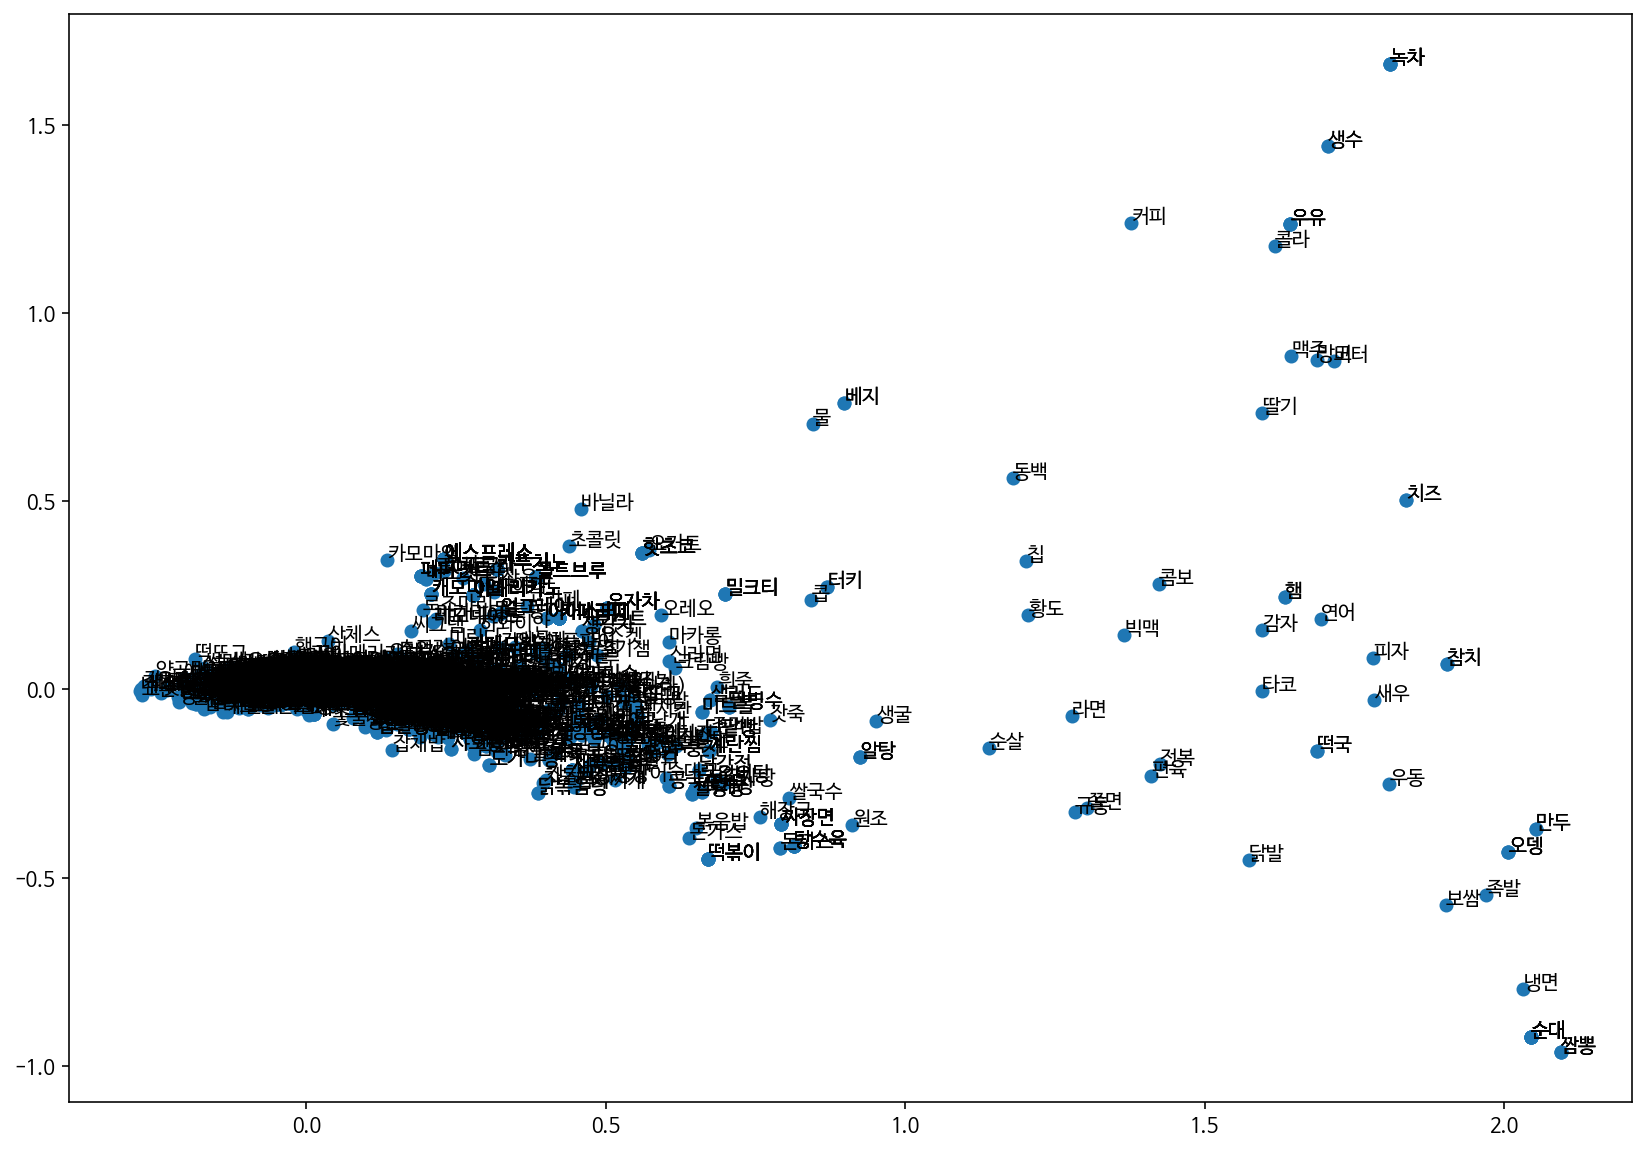

In [ ]:
from sklearn.decomposition import PCA

word_labels = data['상품']

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처 
mpl.rcParams['axes.unicode_minus'] = False 
plt.rc('font', family='NanumBarunGothic') 

pca = PCA(n_components=2)
xys = pca.fit_transform([ft.get_word_vector(w) for w in word_labels])
xs = xys[:,0]
ys = xys[:,1]
plt.figure(figsize=(14, 10))
plt.scatter(xs, ys, marker='o')
for i, v in enumerate(word_labels):
    plt.annotate(v, xy=(xs[i], ys[i]))